In [1]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('model1.h5')
model1 = tf.keras.models.load_model('model1.h5')

# Print the model summary
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 297, 297, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 145, 145, 64)   │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 331776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    42,467,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,501,350 (162.13 MB)

 Trainable params: 42,501,348 (162.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [3]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import numpy as np
import cv2

In [4]:
def load_images_to_dataframe(dataset_dir, target_size=(300, 300)):
    data = []
    labels = []

    for label in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    # Load gambar dan ubah ukuran
                    img = load_img(img_path, target_size=target_size, color_mode="grayscale")
                    img_array = img_to_array(img) / 255.0  # Normalisasi nilai pixel
                    
                    # Cek apakah gambar hitam sepenuhnya
                    if np.all(img_array == 0):
                        print(f"Menghapus gambar hitam: {img_path}")
                        continue  # Lewati gambar hitam
                    
                    data.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    # Konversi ke DataFrame
    df = pd.DataFrame({
        "image": data,
        "label": labels
    })
    return df


In [7]:
df_t = load_images_to_dataframe('Testing')

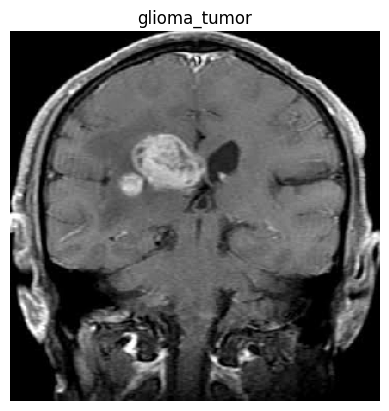

In [9]:
import matplotlib.pyplot as plt

first_image = df_t.iloc[5]['image']

plt.imshow(first_image.squeeze(), cmap='gray')
plt.title(df_t.iloc[5]['label'])
plt.axis('off')
plt.show()

In [10]:
label_mapping = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
df_t['label']= df_t['label'].map(label_mapping)

In [11]:
X_t = np.array(df_t['image'].tolist())
Y_t = df_t['label'].values

In [12]:
from keras.utils import to_categorical
Y_t = to_categorical(Y_t, num_classes=4)

In [13]:
p = model.predict(X_t)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step


In [14]:
from sklearn.metrics import f1_score
from keras.utils import to_categorical

p_labels = np.argmax(p, axis=1)

p_one_hot = to_categorical(p_labels, num_classes=4)

f1 = f1_score(Y_t, p_one_hot, average='weighted')
print("F1-score: ", f1)

F1-score:  0.6877777145823409


In [15]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(np.argmax(Y_t, axis=1), p_labels, target_names=label_mapping.keys())
print(report)

                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.20      0.33       100
meningioma_tumor       0.76      0.96      0.85       115
        no_tumor       0.63      1.00      0.77       105
 pituitary_tumor       0.92      0.73      0.81        74

        accuracy                           0.73       394
       macro avg       0.79      0.72      0.69       394
    weighted avg       0.78      0.73      0.69       394



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Tumor: pituitary_tumor
Accuracy: 99.75%


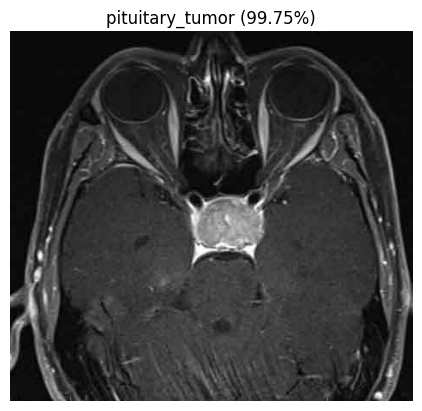

In [17]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

model = load_model('model1.h5')

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

def preprocess_image(image):
    image = cv2.resize(image, (300, 300))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    return image

image_path = 'Testing/pituitary_tumor/image(31).jpg'
image = cv2.imread(image_path)

preprocessed_image = preprocess_image(image)

prediction = model.predict(preprocessed_image)
predicted_label = np.argmax(prediction, axis=1)
predicted_label_name = label_encoder.inverse_transform(predicted_label)[0]
accuracy = np.max(prediction) * 100

print(f'Tumor: {predicted_label_name}')
print(f'Accuracy: {accuracy:.2f}%')

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f'{predicted_label_name} ({accuracy:.2f}%)')
plt.axis('off')
plt.show()
